# This Notebook calculates the Teaserfigure shown in the paper

In [75]:
import ccxt
import pandas as pd
import time

In [76]:
def download_data_from_binance(symbol, start_ts, end_ts):
    # Initialize the Binance API
    binance = ccxt.binance()

    # Define the symbol and timeframe
    timeframe = "1m"  # 1 minute

    # Define the date range
    since = binance.parse8601(start_ts)
    end = binance.parse8601(end_ts)

    # Check if the CSV file already exists.
    # If it does, read the last timestamp to avoid downloading duplicate data.
    try:
        existing_df = pd.read_csv(f"year_{symbol[0:3]}_historical_data_1m.csv")
        # since = pd.to_datetime(existing_df["timestamp"]).max().value // 10**6
        print(f"Resuming from timestamp: {since}")
    except FileNotFoundError:
        # Initialize an empty DataFrame to store the data if the file doesn't exist
        df = pd.DataFrame(
            columns=["timestamp", "open", "high", "low", "close", "volume", "symbol"]
        )
        df.to_csv(f"./{symbol[0:3]}_historical_data_1m.csv", index=False)

    # Loop to paginate through the data
    while since < end:
        print(f"Since: {binance.iso8601(since)}")
        # Download a chunk of historical data
        ohlcv = binance.fetch_ohlcv(symbol, timeframe, since)

        # If no new data, break the loop
        if len(ohlcv) == 0:
            break

        # Convert the chunk to a DataFrame
        chunk_df = pd.DataFrame(
            ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"]
        )

        # Convert the timestamp to a readable date format
        chunk_df["timestamp"] = pd.to_datetime(chunk_df["timestamp"], unit="ms")

        chunk_df["symbol"] = symbol

        # Append the chunk to the CSV file
        chunk_df.to_csv(
            f"./{symbol[0:3]}_historical_data_1m.csv",
            mode="a",
            header=False,
            index=False,
        )

        # Update the 'since' parameter for the next iteration
        since = ohlcv[-1][0] + 1  # Timestamp of the last entry + 1 millisecond

        # Sleep for a while to avoid hitting the API rate limit
        time.sleep(1)

In [77]:
symbol = "SNGLSBTC"
start_ts = "2018-04-10T00:00:00Z"
end_ts = "2018-04-11T00:00:00Z"
download_data_from_binance(symbol, start_ts, end_ts)

Since: 2018-04-10T00:00:00.000Z
Since: 2018-04-10T08:19:00.001Z
Since: 2018-04-10T16:39:00.001Z


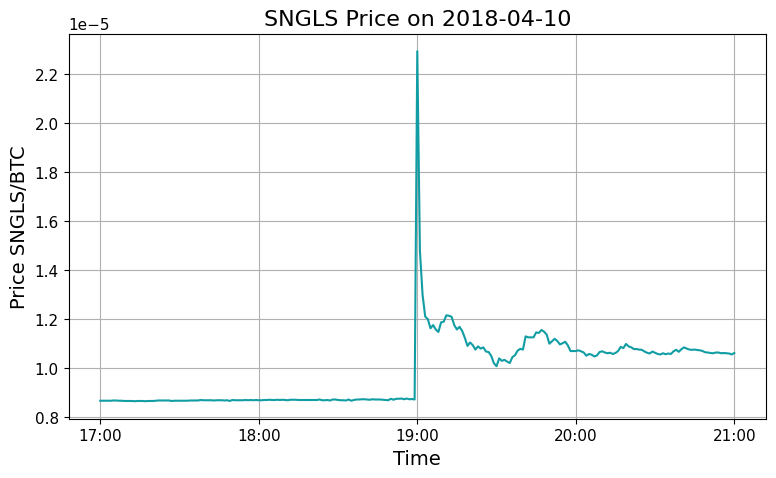

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11


# Load the data
data = pd.read_csv("./SNG_historical_data_1m.csv")

# Convert timestamp to datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Filter the data to only include times between 16:00 and 22:00
data_filtered = data.set_index("timestamp").between_time("17:00", "21:00").reset_index()

# Setting up the plot
plt.figure(figsize=(9, 5))
plt.plot(
    data_filtered["timestamp"],
    data_filtered["high"],
    label="High Price",
    color="#119DA4",
)

# Formatting the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(
    mdates.HourLocator(interval=1)
)  # setting interval to 1 hour
# plt.xticks(rotation=45)

# Other plot settings
plt.xlabel("Time")
plt.ylabel("Price SNGLS/BTC")
plt.title("SNGLS Price on 2018-04-10")
plt.grid(True)
# plt.tight_layout()
plt.savefig("./teaserfigure.png")
plt.show()

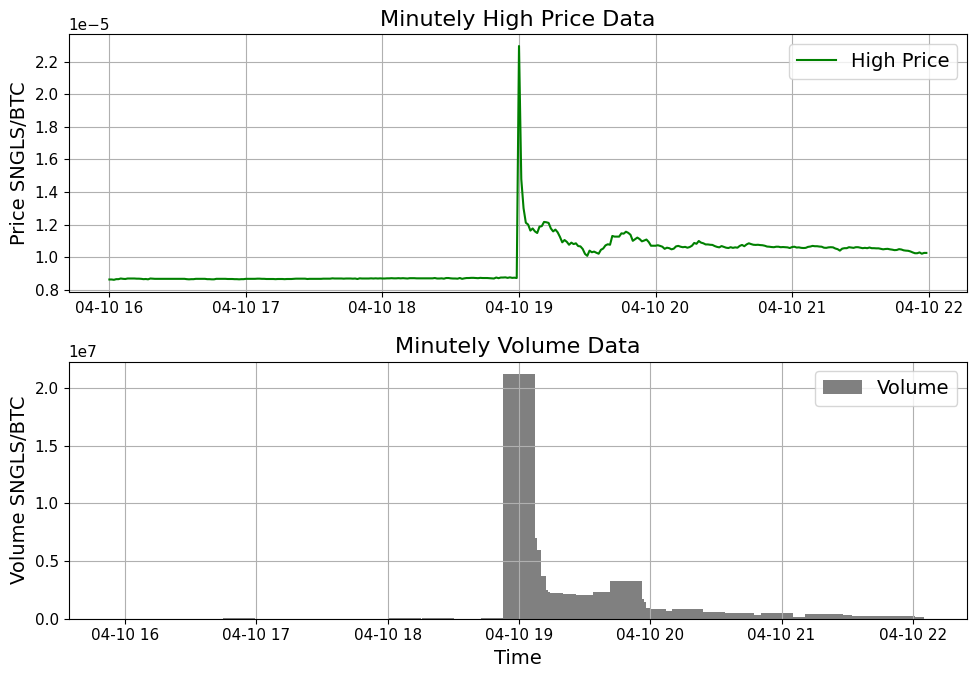

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "./SNG_historical_data_1m.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Convert 'timestamp' to datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Filter the data for the specific time range (14:00 to 24:00)
data_filtered = data[
    (data["timestamp"].dt.hour >= 16) & (data["timestamp"].dt.hour < 22)
]

# Creating separate plots for price and volume with a custom size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))  # Set your desired size here

# Plotting close price on the first subplot
ax1.plot(
    data_filtered["timestamp"], data_filtered["high"], label="High Price", color="green"
)
ax1.set_title("Minutely High Price Data")
ax1.set_ylabel("Price SNGLS/BTC")
ax1.grid(True)
ax1.legend()

# Plotting volume on the second subplot
ax2.bar(
    data_filtered["timestamp"],
    data_filtered["volume"],
    label="Volume",
    color="grey",
    width=0.01,
)
ax2.set_title("Minutely Volume Data")
ax2.set_xlabel("Time")
ax2.set_ylabel("Volume SNGLS/BTC")
ax2.grid(True)
ax2.legend()

plt.savefig("./teaserfigure_2.png")
plt.tight_layout()
plt.show()